In this file, we amplitude encode nouns represented by four dimensional vectors in classical vector spaces onto Hilbert spaces spanned by two qubits. 

We use three different models for the QNLP workflow:
    - Numpy model 
    - Tket model 
    - Pennylane model 

And we use different methods of amplitude encoding:
    - Encoding of Wikipedia2Vec 
    - Encoding of Naive assumption 
    - Encoding of Baseline (all nouns initialized to |00>)

In [2]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [3]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 100
LEARNING_RATE = 3e-2
SEED = 2

In [4]:

# load training data 

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, forget  = read_data('../datasets/mc_train_data.txt')
test_labels, forget = read_data('../datasets/mc_test_data.txt')
val_labels, forget = read_data('../datasets/mc_dev_data.txt')


# here, we can choose between either the original dataset by Coecke et al. or the new one for Gijs' data

gijs = True

if not gijs: 
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/newTestSentences.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/newTrainSentences.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/newValSentences.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


if gijs:
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/testGijs.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/trainGijs.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/valGijs.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


In [5]:
# parse sentences from data to diagrams 

from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


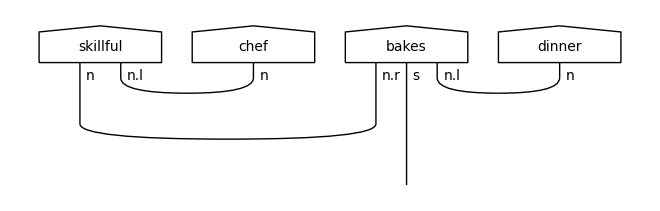

In [6]:
raw_train_diagrams[1].draw()

In [7]:
# normalising by removing cups 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]



In [32]:
'''
This is new when amplitude encoding: 

we include the dictionary indicating what four dimensional word vector to use for what word 

'''

import json

# wiki2vec
with open("../datasets/newNounVectorsICA.json", 'r') as fp:
    parameterDict = json.load(fp)

# extreme encodes all words to two extreme sides of the bloch sphere 
# with open("../datasets/extremeNounVectors.json", 'r') as fp:
#     parameterDict = json.load(fp)

# trivial encodes all words to [0,0,0,0]
# with open("../datasets/trivialNounVectors.json", 'r') as fp:
#     parameterDict = json.load(fp)


The number of noun parameters does not fit the number of single qubit operators. 
params in circuitfunction: [[chef__n_0]]
thetas:  [chef__n_0]
we have to do somehting
the word is:   chef
is it daggered?  False
and the parameters are:  [-0.047238498013075565, 0.007420470794743872, -0.24961354648963952, -0.967164173409829]
vector to amplitude encode:  [-0.0472385   0.00742047 -0.24961355 -0.96716417]
params in circuitfunction: [[prepares__n.r@s@n.l_0 prepares__n.r@s@n.l_1 prepares__n.r@s@n.l_2
  prepares__n.r@s@n.l_3]]
thetas:  [prepares__n.r@s@n.l_0 prepares__n.r@s@n.l_1 prepares__n.r@s@n.l_2
 prepares__n.r@s@n.l_3]
params in circuitfunction: [[sauce†_n__0]]
thetas:  [sauce†_n__0]
we have to do somehting
the word is:   sauce
is it daggered?  True
and the parameters are:  [0.994249147640429, -0.10584831803711221, -0.016250733881613674, -0.0008243987529197505]
vector to amplitude encode:  [ 9.94249148e-01 -1.05848318e-01 -1.62507339e-02 -8.24398753e-04]
params in circuitfunction: [[skill

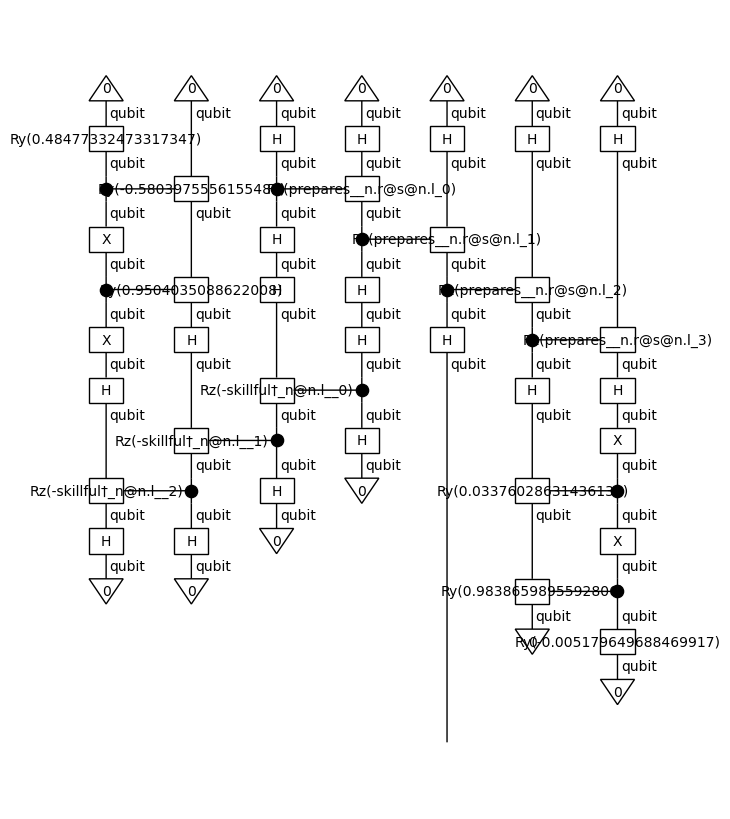

In [33]:
# create quantum circuits using the amplitude encoding ansatz

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

# replace the naive way of encoding with the amplitude encoding Code developed in the file IQPAmplitudeEncoding.py 
from IQPAmplitudeEncode import * 

# the corresponding function is IQPAmplitudeEncode2QB
ansatz = IQPAmplitudeEncode2QB({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                   n_layers=1, nounParams=np.array([1,2,3,4, 1,2,3,4,]), parameterDict=parameterDict, n_single_qubit_params=3)


train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

First model: Pennylane 

In [34]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
modelPennylane = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
modelPennylane.initialise_weights()



In [35]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
val_dataset = Dataset(val_circuits, val_labels)

In [36]:
def accPL(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [37]:
from lambeq import PytorchTrainer
import torch

trainerPennylane = PytorchTrainer(
    model=modelPennylane,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accPL},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [38]:
# trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

trainerPennylane.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.1504   valid/loss: 0.2128   train/acc: 0.5429   valid/acc: 0.6333
Epoch 2:    train/loss: 0.1111   valid/loss: 0.1805   train/acc: 0.6857   valid/acc: 0.7000
Epoch 3:    train/loss: 0.0902   valid/loss: 0.1581   train/acc: 0.7000   valid/acc: 0.6667
Epoch 4:    train/loss: 0.1843   valid/loss: 0.1234   train/acc: 0.7143   valid/acc: 0.7667
Epoch 5:    train/loss: 0.2465   valid/loss: 0.1317   train/acc: 0.7429   valid/acc: 0.8333
Epoch 6:    train/loss: 0.1651   valid/loss: 0.1416   train/acc: 0.7857   valid/acc: 0.8000
Epoch 7:    train/loss: 0.2240   valid/loss: 0.1446   train/acc: 0.7714   valid/acc: 0.8000
Epoch 8:    train/loss: 0.1306   valid/loss: 0.1432   train/acc: 0.7571   valid/acc: 0.7667
Epoch 9:    train/loss: 0.1110   valid/loss: 0.1376   train/acc: 0.7714   valid/acc: 0.8333
Epoch 10:   train/loss: 0.1532   valid/loss: 0.1386   train/acc: 0.7571   valid/acc: 0.8000
Epoch 11:   train/loss: 0.0838   valid/loss: 0.1366   train/acc: 0.7714   valid/

Second model: Numpy 

In [39]:
# Do the same thing, but now using the NUMPY model! 

from lambeq import NumpyModel

modelNumpy = NumpyModel.from_diagrams(all_circuits, use_jit=False)


from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

accNP = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": accNP}


# NUMPY model uses QuantumTrainer class 

from lambeq import QuantumTrainer, SPSAOptimizer

trainerNumpy = QuantumTrainer(
    modelNumpy,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)




In [40]:
# train the numpy model 

trainerNumpy.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.8895   valid/loss: 0.7332   train/acc: 0.4571   valid/acc: 0.6667
Epoch 2:    train/loss: 0.6072   valid/loss: 0.8477   train/acc: 0.5143   valid/acc: 0.5333
Epoch 3:    train/loss: 0.6521   valid/loss: 0.9306   train/acc: 0.5429   valid/acc: 0.4667
Epoch 4:    train/loss: 0.8139   valid/loss: 0.8157   train/acc: 0.5857   valid/acc: 0.5667
Epoch 5:    train/loss: 0.7418   valid/loss: 0.7984   train/acc: 0.6286   valid/acc: 0.5667
Epoch 6:    train/loss: 0.4869   valid/loss: 0.8157   train/acc: 0.5857   valid/acc: 0.5667
Epoch 7:    train/loss: 0.8205   valid/loss: 0.8922   train/acc: 0.5429   valid/acc: 0.5667
Epoch 8:    train/loss: 0.5514   valid/loss: 0.8187   train/acc: 0.6286   valid/acc: 0.6000
Epoch 9:    train/loss: 0.7345   valid/loss: 0.8114   train/acc: 0.6000   valid/acc: 0.6000
Epoch 10:   train/loss: 0.5515   valid/loss: 0.8167   train/acc: 0.5857   valid/acc: 0.6000
Epoch 11:   train/loss: 0.3701   valid/loss: 0.7802   train/acc: 0.6143   valid/

Third model: Tket 

In [41]:
'''
Same thing, but for Tket model 
'''

from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 2.7489   valid/loss: 2.3499   train/acc: 0.5643   valid/acc: 0.4333
Epoch 2:    train/loss: 0.5780   valid/loss: 2.0416   train/acc: 0.5929   valid/acc: 0.4667
Epoch 3:    train/loss: 1.4669   valid/loss: 1.0384   train/acc: 0.6000   valid/acc: 0.8000
Epoch 4:    train/loss: 2.3227   valid/loss: 1.9496   train/acc: 0.6857   valid/acc: 0.5667
Epoch 5:    train/loss: 3.7344   valid/loss: 3.2486   train/acc: 0.4571   valid/acc: 0.2000
Epoch 6:    train/loss: 1.9139   valid/loss: 3.6553   train/acc: 0.3643   valid/acc: 0.4167
Epoch 7:    train/loss: 1.4880   valid/loss: 3.1783   train/acc: 0.5929   valid/acc: 0.5667
Epoch 8:    train/loss: 3.6372   valid/loss: 1.2283   train/acc: 0.5929   valid/acc: 0.6333
Epoch 9:    train/loss: 4.9192   valid/loss: 2.6424   train/acc: 0.4786   valid/acc: 0.6000
Epoch 10:   train/loss: 3.9109   valid/loss: 3.5574   train/acc: 0.4571   valid/acc: 0.5500
Epoch 11:   train/loss: 4.7799   valid/loss: 2.3272   train/acc: 0.5071   valid/

In [51]:
'''
Before we look at the results of the training, let us understand what exactly these circuits are that we trained above. 

We start by extracting the parameters for the symbols learned by Coecke et al. 


'''

# The symbols are the names of the respective parameters for the respective words
smbls = modelTK.symbols

# And the weights are their respective values 
weights = modelTK.weights

print('symbols: ', smbls)
print('weights: ', weights)

# now, we are only interested in the noun weights 

newSmbls = []
newWeights = []

verbSmbls = []
verbWeights = []

adjSmbls = []
adjWeights = []

for i in range(len(weights)): 
    if '__n_' in str(smbls[i]):# or '_N†_n__' in str(smbls[i]):
        newSmbls.append(smbls[i])
        newWeights.append(weights[i].item())
    elif 'TV' in str(smbls[i]): 
        verbSmbls.append(smbls[i])
        verbWeights.append(weights[i].item())
    elif 'ADJ' in str(smbls[i]): 
        adjSmbls.append(smbls[i])
        adjWeights.append(weights[i].item())


# create a simple dictionary for parameters and weights 
parameterDict = {}
for i in range(len(smbls)):
    parameterDict[str(smbls[i])] = weights[i].item()

print(parameterDict)

import pickle

with open('../datasets/weightsDictTKGijs2QBAEICA.pkl', 'wb') as fp:
    pickle.dump(parameterDict, fp)


print(newSmbls)
print(newWeights)


symbols:  [bakes__n.r@s@n.l_0, bakes__n.r@s@n.l_1, bakes__n.r@s@n.l_2, bakes__n.r@s@n.l_3, cooks__n.r@s@n.l_0, cooks__n.r@s@n.l_1, cooks__n.r@s@n.l_2, cooks__n.r@s@n.l_3, prepares__n.r@s@n.l_0, prepares__n.r@s@n.l_1, prepares__n.r@s@n.l_2, prepares__n.r@s@n.l_3, reads__n.r@s@n.l_0, reads__n.r@s@n.l_1, reads__n.r@s@n.l_2, reads__n.r@s@n.l_3, runs__n.r@s@n.l_0, runs__n.r@s@n.l_1, runs__n.r@s@n.l_2, runs__n.r@s@n.l_3, skillful†_n@n.l__0, skillful†_n@n.l__1, skillful†_n@n.l__2, tasty†_n@n.l__0, tasty†_n@n.l__1, tasty†_n@n.l__2, useful†_n@n.l__0, useful†_n@n.l__1, useful†_n@n.l__2]
weights:  [ 0.66267592  0.31595712 -2.25978541  0.80954411  2.75645735  2.46087407
 -0.92674943  5.05558619  4.48661904  2.99068402  5.69132021  4.67492449
 -2.3340813   0.00653845 -3.29130751  2.84906356 -0.10673454 -0.91380487
  3.17539732  2.70484961 -2.81749247  0.82279362  1.47720925  0.27407034
  1.42209875 -0.97598114  1.45071763 -0.51517748  1.51584824]
{'bakes__n.r@s@n.l_0': 0.6626759161265012, 'bakes__n

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


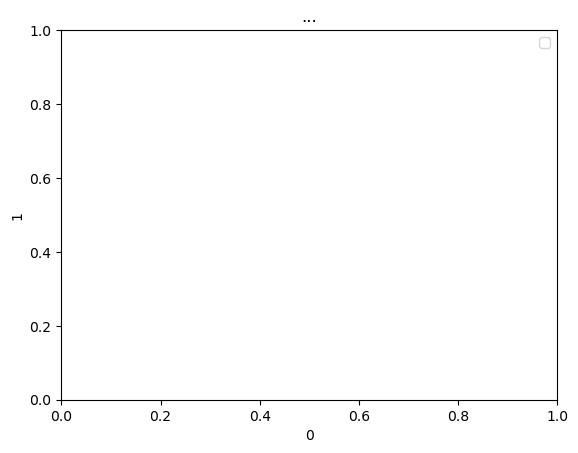

In [43]:
'''
We want to see to what exact quantum states the respective nouns are mapped. We define a qiskit circuit consisting of a Rx, Rz, and Rx gate and we look at the quantum 
states that the respective nouns are mapped to. 
'''
# import matplotlib
from qiskit import QuantumCircuit, Aer, execute

def getProbDist(listOfParams): 
    '''
    Given a list of parameters, this function creates a circuit and returns the state and the probability distribution of said state
    '''

    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1, 1)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)

    # Apply Rx and Rz gates
    qc.rx(listOfParams[0], 0)
    qc.rz(listOfParams[1], 0) 
    qc.rx(listOfParams[2], 0)


    # statevectors simulator for UNMEASURED CIRCUIT
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=backend, shots = 1, memory = True)
    stateVector = job.result().get_statevector(qc)


    # Measure the qubit
    qc.measure(0, 0)  # Measure qubit 0 and store the result in classical bit 0

    # Draw the circuit (optional)
    # print("Quantum Circuit:")
    # qc.draw(output='mpl', filename = 'testtesttest.png')

    # Use the Aer simulator to execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist, stateVector


NounsAndVecs = {}
nounStateList = []

# for plotting the Bloch spheres
from qiskit.visualization import plot_bloch_multivector

for i in range(0, len(newWeights), 3): 

    params = newWeights[i:i+3]

    # print(newSmbls[i:i+3])

    # print(params)

    probDist, nounState = getProbDist(params)

    nounStateList.append(nounState)

    # plot bloch sphere 
    print('Symbol = ', str(newSmbls[i]))
    print('Statevector = ', str(nounState))
    plot_bloch_multivector(nounState, title=str(newSmbls[i]), filename = 'blochMultivector' + str(i) + '.png')

    NounsAndVecs[str(newSmbls[i])] = probDist

    # plot in 2-dim cartesian system
    plt.text(np.sqrt(probDist['0']), np.sqrt(probDist['1']), str(newSmbls[i]), fontsize = 5)


plt.title('...')
plt.ylabel('1')
plt.xlabel('0')
plt.legend()
plt.show()
# print(NounsAndVecs)



In [44]:
'''
We see that there is *no* system whatsoever. 
This might be due to the poor training as we can see in the plots below. 

I could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)

Later, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. 


NEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO 

'''

"\nWe see that there is *no* system whatsoever. \nThis might be due to the poor training as we can see in the plots below. \n\nI could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)\n\nLater, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. \n\n\nNEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO \n\n"

In [45]:
def VerbCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(3)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)
    qc.initialize(initial_state, 2)

    qc.h(range(3))

    # add CNOT gates 
    qc.crz(paramList[0], 2, 1)
    qc.crz(paramList[1], 1, 0)

    qc.h(range(3))

    if draw: 
        print(qc)
        qc.draw(output='mpl', filename='verbCircuit.png')
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(VerbCircuit([1,2], draw= True))



     ┌─────────────────┐┌───┐         ┌───────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├─────────┤ Rz(2) ├┤ H ├
     ├─────────────────┤├───┤┌───────┐└───┬───┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├┤ Rz(1) ├────■────┤ H ├
     ├─────────────────┤├───┤└───┬───┘  ┌───┐  └───┘
q_2: ┤ Initialize(1,0) ├┤ H ├────■──────┤ H ├───────
     └─────────────────┘└───┘           └───┘       


/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


{'000': 5.25780934030603e-06, '001': 1.66183287836071e-06, '010': 8.0643771242442e-07, '011': 1.66183287836071e-06, '100': 5.257933299646e-08, '101': 1.0835066732322e-07, '110': 3.4280652290523e-07, '111': 1.0835066732322e-07}


In [46]:
'''
Now, the same thing for adjectives
'''

def AdjectivesCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(2)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)

    qc.h(range(2))

    # add CNOT gates 
    qc.crz(paramList[0], 1, 0)

    qc.h(range(2))

    if draw: 
        print(qc)
        qc.draw(output='mpl', filename='adjCircuit.png')
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(AdjectivesCircuit([3.14], draw= True))



     ┌─────────────────┐┌───┐┌──────────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├┤ Rz(3.14) ├┤ H ├
     ├─────────────────┤├───┤└────┬─────┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├─────■──────┤ H ├
     └─────────────────┘└───┘            └───┘
{'00': 2.50398321889424e-06, '01': 2.49999841465942e-06, '10': 2.49601995178691e-06, '11': 2.49999841465942e-06}


Final test accuracy: 0.9333333333333333
Validation accuracy: 0.65


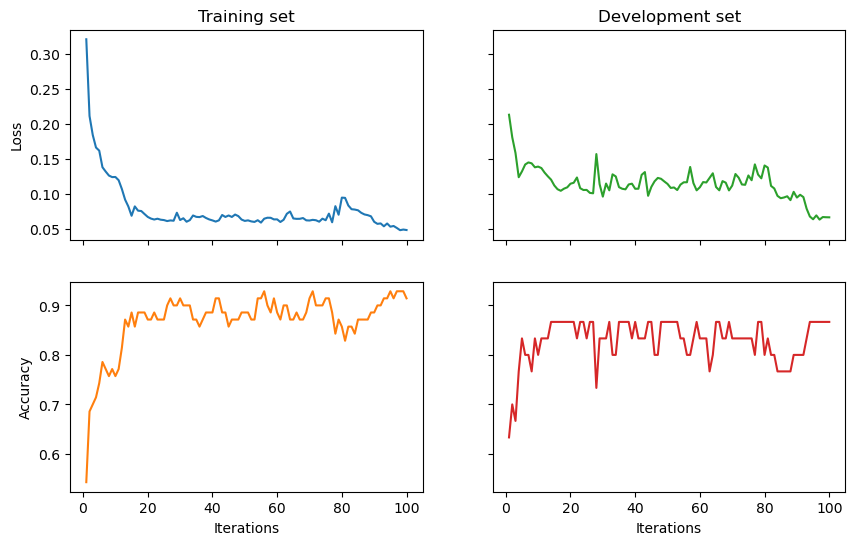

In [55]:
'''
Performance of the model!! 
'''


import matplotlib.pyplot as plt

trainer = trainerPennylane
model = modelPennylane
acc = accPL
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

# print test accuracy - tket
modelTK.load(trainerTK.log_dir + '/best_model.lt')
val_acc = accTK(modelTK(val_circuits), val_labels)
print('Validation accuracy:', val_acc.item())

In [48]:
'''
Now, for the density matrix part. 
We write a qiskit circuit and we predict, given the weights, the density matrices with the nouns missing
''' 
from qiskit import QuantumCircuit

a = modelNumpy.get_diagram_output(test_circuits)
print(len(a))

print(a)

# print(len(test_circuits))
# print(len(pred))

30
[[0.4561248  0.5438752 ]
 [0.24558295 0.75441705]
 [0.33795687 0.66204313]
 [0.73502102 0.26497898]
 [0.64379845 0.35620155]
 [0.09754597 0.90245403]
 [0.4802906  0.5197094 ]
 [0.41738284 0.58261716]
 [0.50899318 0.49100682]
 [0.18665325 0.81334675]
 [0.77394121 0.22605879]
 [0.41531908 0.58468092]
 [0.33535569 0.66464431]
 [0.53763365 0.46236635]
 [0.43235196 0.56764804]
 [0.5397972  0.4602028 ]
 [0.33757903 0.66242097]
 [0.20615164 0.79384836]
 [0.55439044 0.44560956]
 [0.62626781 0.37373219]
 [0.23590936 0.76409064]
 [0.65817729 0.34182271]
 [0.50626095 0.49373905]
 [0.36634038 0.63365962]
 [0.60766593 0.39233407]
 [0.34882602 0.65117398]
 [0.78020696 0.21979304]
 [0.83721048 0.16278952]
 [0.5727571  0.4272429 ]
 [0.52196262 0.47803738]]
